In [2]:
!pip install torch transformers datasets accelerate trl sentence-transformers diskcache bitsandbytes spacy networkx -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 14.3 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
dataset = load_dataset("gsm8k", "main")["train"]
dataset = dataset.shuffle(seed=42)
subset = dataset.select(range(len(dataset) // 3))
print(f"Training samples: {len(subset)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Training samples: 2491


In [ ]:
from huggingface_hub import login

login("key")

In [60]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
import spacy
import networkx as nx
import torch
from trl import PPOTrainer, PPOConfig
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [8]:
nlp = spacy.load("en_core_web_sm")
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [29]:
def build_graph_and_mask(prompt_text, keep_ratio=0.4, sim_threshold=0.75):
    doc = nlp(prompt_text)
    tokens = [t.text for t in doc]

    # initialize directed graph
    G = nx.DiGraph()
    for i, t in enumerate(doc):
        G.add_node(i, text=t.text, pos=t.pos_)

    # --- Syntactic edges (dependency tree) ---
    for t in doc:
        if t.dep_ != "punct" and t.head.i != t.i:
            G.add_edge(t.head.i, t.i)

    # --- Semantic edges (filtered) ---
    content_idx = [
        i for i, t in enumerate(doc)
        if not t.is_stop and t.is_alpha and t.pos_ in {"NOUN", "VERB", "ADJ", "NUM"}
    ]
    if len(content_idx) > 1:
        token_embs = embedder.encode([tokens[i] for i in content_idx],
                                     normalize_embeddings=True)
        for a, i in enumerate(content_idx):
            for b, j in enumerate(content_idx):
                if i != j:
                    sim = float(token_embs[a] @ token_embs[b].T)
                    if sim > sim_threshold:
                        G.add_edge(i, j)

    # --- Compute importance (centrality) ---
    pr = nx.pagerank(G, alpha=0.85)
    ranked = sorted(pr.items(), key=lambda x: x[1], reverse=True)
    k = max(1, int(len(tokens) * keep_ratio))
    keep_idx = set(i for i, _ in ranked[:k])
    mask = [1 if i in keep_idx else 0 for i in range(len(tokens))]



    return tokens, mask, G

In [30]:
sample = "If it takes 5 machines 5 minutes to make 5 widgets, how long will it take 100 machines to make 100 widgets?"
tokens, mask, G = build_graph_and_mask(sample)

print("Tokens:", tokens)
print("Mask:", mask)
print("\nGraph edges:")
for u, v in G.edges():
    print(f"{tokens[u]} → {tokens[v]}")


Tokens: ['If', 'it', 'takes', '5', 'machines', '5', 'minutes', 'to', 'make', '5', 'widgets', ',', 'how', 'long', 'will', 'it', 'take', '100', 'machines', 'to', 'make', '100', 'widgets', '?']
Mask: [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]

Graph edges:
takes → If
takes → it
takes → machines
takes → minutes
takes → make
machines → 5
machines → machines
minutes → 5
make → to
make → widgets
widgets → 5
widgets → widgets
long → how
take → takes
take → long
take → will
take → it
take → machines
take → make
machines → 100
machines → machines
make → to
make → widgets
widgets → 100
widgets → widgets


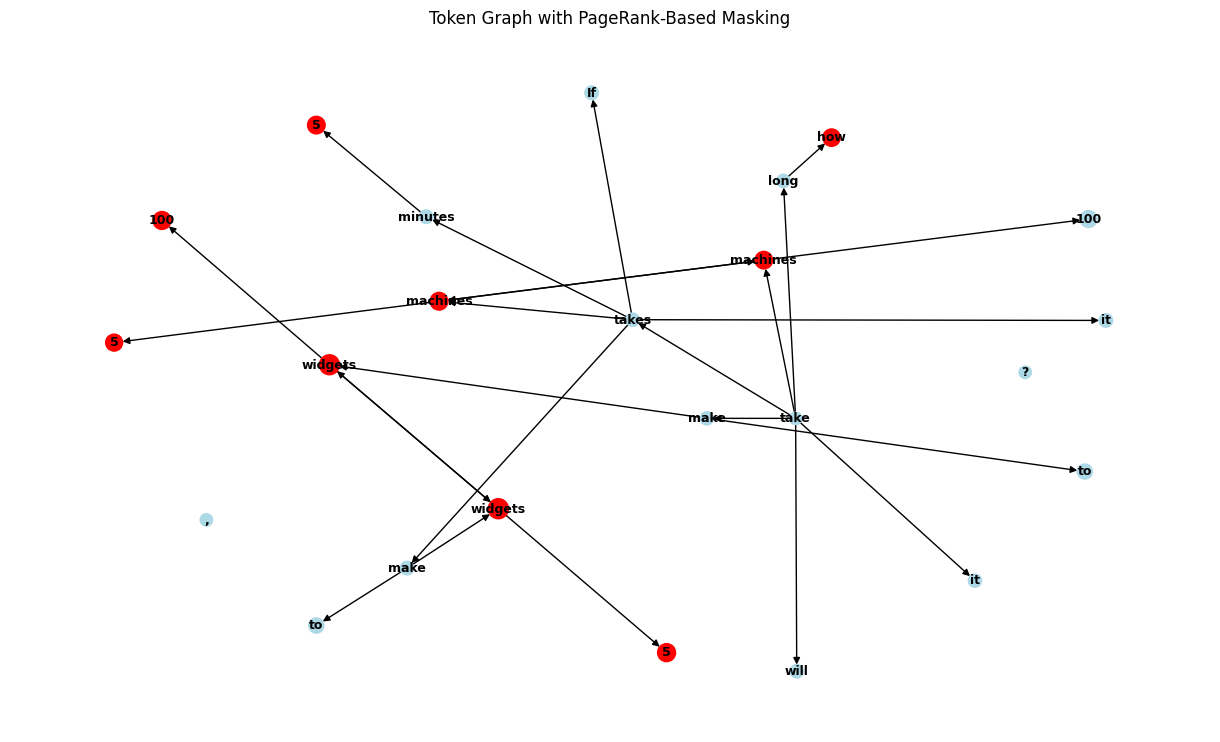

In [31]:
pr = nx.pagerank(G, alpha=0.85)
sizes = [3000 * pr[i] for i in range(len(tokens))]
colors = ['red' if mask[i] == 1 else 'lightblue' for i in range(len(tokens))]

plt.figure(figsize=(12, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, labels={i: tokens[i] for i in range(len(tokens))},
        node_color=colors, node_size=sizes, font_size=9, font_weight="bold")
plt.title("Token Graph with PageRank-Based Masking")
plt.show()


In [33]:
# Frozen evaluator (Gemma)
gemma = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b",
    dtype=torch.float16,
    device_map="auto"
).eval()
tokenizer_gemma = AutoTokenizer.from_pretrained("google/gemma-2b")
for p in gemma.parameters():
    p.requires_grad = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [34]:
def gemma_generate(model, tokenizer, prompt, max_new_tokens=64):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [35]:
def compute_reward(orig_out, comp_out, orig_prompt, comp_prompt):
    emb1 = embedder.encode([orig_out], normalize_embeddings=True)[0]
    emb2 = embedder.encode([comp_out], normalize_embeddings=True)[0]
    r_sem = float(np.dot(emb1, emb2))
    r_comp = 1 - len(comp_prompt.split()) / max(1, len(orig_prompt.split()))
    r_reason = (r_sem + r_comp) / 2
    return 0.5*r_sem + 0.3*r_reason + 0.2*r_comp


In [44]:
class RewardModel(torch.nn.Module):
    def __init__(self, gemma_model, gemma_tokenizer, embedder):
        super().__init__()
        self.gemma = gemma_model
        self.tokenizer = gemma_tokenizer
        self.embedder = embedder

    def forward(self, prompts, responses):
        rewards = []
        for prompt, response in zip(prompts, responses):
            # generate Gemma output
            gemma_out = gemma_generate(self.gemma, self.tokenizer, prompt)
            # compute reward (using your embedding-based function)
            reward = compute_reward(response, gemma_out, prompt, prompt)
            rewards.append(reward)
        return torch.tensor(rewards, dtype=torch.float32, device=self.gemma.device)

reward_model = RewardModel(gemma, tokenizer_gemma, embedder).to(device)

In [57]:
# Tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

# Actor
actor = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

# Reference
ref_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
for p in ref_model.parameters():
    p.requires_grad = False

In [59]:
ppo_args = PPOConfig(
    exp_name="gsm8k_ppo",
    num_ppo_epochs=3,
    per_device_train_batch_size=2,  # keep small if GPU is limited
    learning_rate=5e-6,
    fp16=True,
    whiten_rewards=False  # avoid minibatch size >=8 requirement
)

trainer = PPOTrainer(
    processing_class=tokenizer_gpt,
    model=actor,
    ref_model=ref_model,
    reward_model=reward_model,
    train_dataset=subset,
    value_model=actor,
    args=ppo_args
)